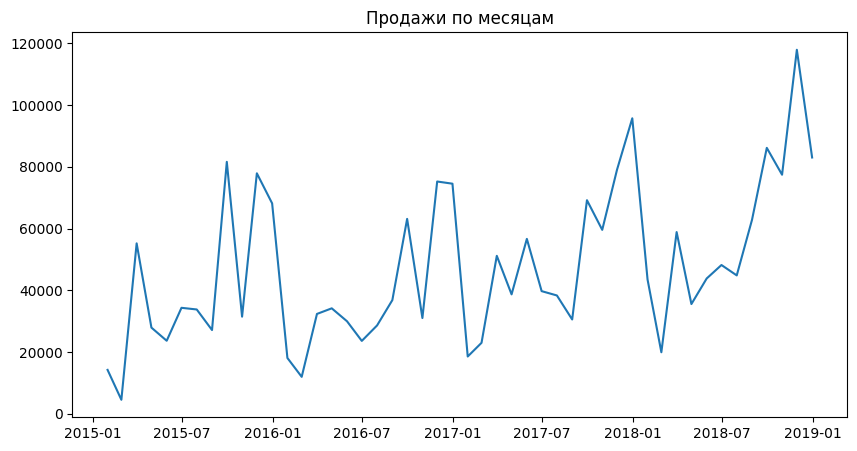

ADF Statistic: -4.416136761430769
p-value: 0.00027791039276670623
                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -539.293
Date:                Fri, 21 Mar 2025   AIC                           1084.585
Time:                        11:40:02   BIC                           1090.136
Sample:                             0   HQIC                          1086.674
                                 - 48                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2546      0.265      0.961      0.337      -0.265       0.774
ma.L1         -0.8477      0.144     -5.898      0.000      -1.12

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Загружаем данные Superstore
df = pd.read_csv('Superstore.csv')  # Укажи путь к файлу

# Преобразуем даты с правильным форматом
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y', dayfirst=True)

# Группируем продажи по месяцам
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum().reset_index()

# Визуализируем ряд
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales['Order Date'], monthly_sales['Sales'])
plt.title('Продажи по месяцам')
plt.show()

# Проверяем стационарность (ADF-тест)
result = adfuller(monthly_sales['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# Если p-value > 0.05, ряд не стационарный, нужно дифференцирование (d=1)

# ARIMA модель (p=1, d=1, q=1 для начала)
model = ARIMA(monthly_sales['Sales'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Прогноз на 1 месяц
forecast = model_fit.forecast(steps=1)
print("Прогноз на следующий месяц:", forecast)

11:48:14 - cmdstanpy - INFO - Chain [1] start processing
11:48:15 - cmdstanpy - INFO - Chain [1] done processing


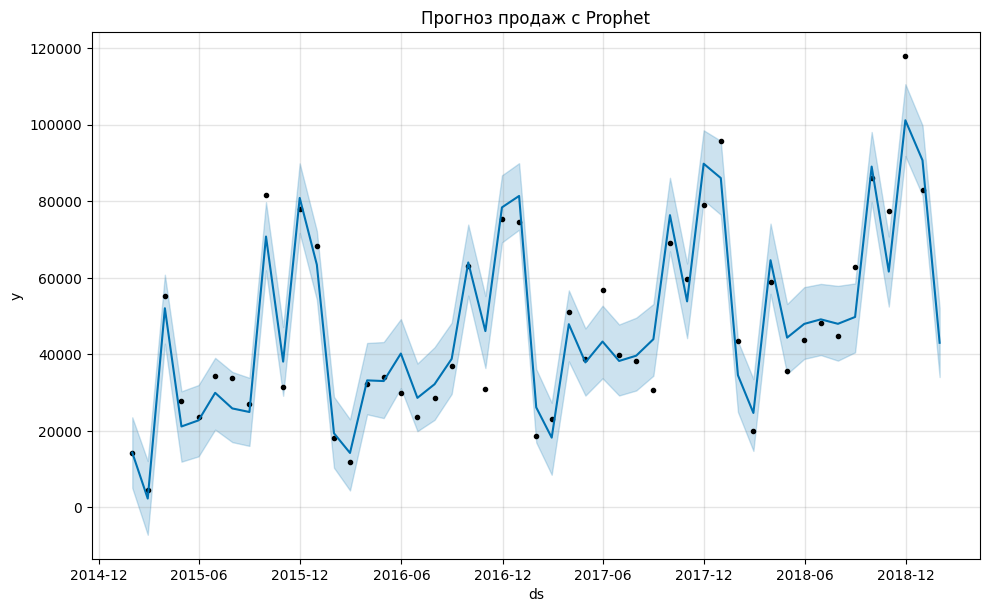

Прогноз на следующий месяц:            ds         yhat    yhat_lower    yhat_upper
48 2019-01-31  42990.56853  34039.952101  52080.937076


In [6]:
from prophet import Prophet

# Подготовим данные для Prophet
prophet_data = monthly_sales.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Создаём и обучаем модель
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_data)

# Создаём будущие даты (1 месяц)
future = model.make_future_dataframe(periods=1, freq='ME')
forecast = model.predict(future)

# Визуализируем
model.plot(forecast)
plt.title('Прогноз продаж с Prophet')
plt.show()

# Выводим прогноз
print("Прогноз на следующий месяц:", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(1))

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Исторические данные (с февраля 2015 по декабрь 2018, исключаем январь 2019)
actual = monthly_sales['Sales'][:-1]  # 47 элементов (с 0 по 46)

# Прогноз ARIMA на исторических данных
# start=1 означает, что прогноз начинается со второго элемента (индекс 1)
arima_forecast = model_fit.predict(start=1, end=len(monthly_sales)-1)  # 47 элементов (с 1 по 47)

# Прогноз Prophet на исторических данных
# forecast['yhat'] имеет 49 элементов (48 исторических + 1 прогнозный)
# Обрезаем с 1 по 47, чтобы соответствовать arima_forecast
prophet_forecast = forecast['yhat'][1:-1]  # 47 элементов (с февраля 2015 по декабрь 2018)

# Проверяем длины
print("Длина actual:", len(actual))
print("Длина arima_forecast:", len(arima_forecast))
print("Длина prophet_forecast:", len(prophet_forecast))

# Считаем метрики
arima_mae = mean_absolute_error(actual, arima_forecast)
prophet_mae = mean_absolute_error(actual, prophet_forecast)
arima_rmse = np.sqrt(mean_squared_error(actual, arima_forecast))
prophet_rmse = np.sqrt(mean_squared_error(actual, prophet_forecast))

print("ARIMA MAE:", arima_mae)
print("Prophet MAE:", prophet_mae)
print("ARIMA RMSE:", arima_rmse)
print("Prophet RMSE:", prophet_rmse)

Длина actual: 47
Длина arima_forecast: 47
Длина prophet_forecast: 47
ARIMA MAE: 10688.25679896529
Prophet MAE: 20203.812463737166
ARIMA RMSE: 14012.319274348412
Prophet RMSE: 26309.68920908744
